# Transformers desde (casi) cero

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-nlp/blob/main/Sesion3/1-transformers-from-scratch.ipynb)

En este notebook implementaremos un clasificador de noticias en español utilizando transformers. Implementaremos parte de la arquitectura del modelo pieza por pieza para ver como funciona por dentro. Sin embargo, utilizarémos las utilidades de tokenización de huggingface transformers para ayudarnos con esta tarea.

#### Referencias
- Dataset: https://huggingface.co/datasets/MarcOrfilaCarreras/spanish-news
- [Attention is All You Need](http://arxiv.org/abs/1706.03762)
- [Natural Language Processing with Transformers: Building Language Applications With Hugging Face](https://www.amazon.com/Natural-Language-Processing-Transformers-Applications/dp/1098103246)
- [Tutorial 5: Transformers and Multi-Head Attention](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html)

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [ ]:
#!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-nlp/raw/refs/heads/main/requirements.txt && pip install -r requirements.txt
!test '{IN_COLAB}' = 'True' && sudo apt-get update -y
!test '{IN_COLAB}' = 'True' && sudo apt-get install python3.10 python3.10-distutils python3.10-lib2to3 -y
!test '{IN_COLAB}' = 'True' && sudo update-alternatives --install /usr/local/bin/python python /usr/bin/python3.11 2
!test '{IN_COLAB}' = 'True' && sudo update-alternatives --install /usr/local/bin/python python /usr/bin/python3.10 1
!test '{IN_COLAB}' = 'True' && pip install lightning datasets 'transformers[torch]' sentence-transformers

### Cargando el dataset
Este es un dataset pequeño de articulos de noticias en idioma español con sus respectivas categorías. El dataset está disponible en el HuggingFace Hub y puede ser fácilmente descargado con la librería.

In [1]:
from datasets import load_dataset
import warnings
import os

warnings.filterwarnings("ignore")
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
dataset = load_dataset("wikiann", "es", split='train')
dataset

/home/luis/anaconda3/envs/nlp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'spans'],
    num_rows: 20000
})

## DATASET wikiANN (es)

#### **Columnas principales**

* `tokens`: Lista de palabras (ej. `["José", "Luis", "García"]`).
* `ner_tags`: Lista de enteros que representan etiquetas IOB.
* `langs`: Idioma por token (aquí siempre `"es"`).
* `spans`: Entidades completas (ej. `"PER: José Luis García"`).

#### **Formato de Etiquetas (IOB)**

El dataset usa un esquema IOB con 3 tipos de entidades: **Persona (PER)**, **Organización (ORG)** y **Lugar (LOC)**.

| ID | Tag   | Significado               |
| -- | ----- | ------------------------- |
| 0  | O     | Outside (ninguna entidad) |
| 1  | B-PER | Beginning of Person       |
| 2  | I-PER | Inside Person             |
| 3  | B-ORG | Beginning of Organization |
| 4  | I-ORG | Inside Organization       |
| 5  | B-LOC | Beginning of Location     |
| 6  | I-LOC | Inside Location           |

**Número de etiquetas (`num_labels`) = 7**

#### **Ejemplo de muestra**

```python
{
 'tokens': ['REDIRECCIÓN', 'José', 'Luis', 'García'],
 'ner_tags': [0, 1, 2, 2],
 'langs': ['es', 'es', 'es', 'es'],
 'spans': ['PER: José Luis García']
}
```

Interpretación:

```
'REDIRECCIÓN' → O
'José'        → B-PER
'Luis'        → I-PER
'García'      → I-PER
```

In [2]:
dataset[7]

{'tokens': ['Condado', 'de', 'Duplin', 'suroeste'],
 'ner_tags': [5, 6, 6, 0],
 'langs': ['es', 'es', 'es', 'es'],
 'spans': ['LOC: Condado de Duplin']}

Para los efectos de esta tarea, nos servirán el texto y la categoría naturalmente.

A manera general, observemos que tan largos o cortos tienden a ser los textos.

In [3]:
text_lengths = [len(row['tokens']) for row in dataset]
print(f"Texto más corto: {min(text_lengths)}")
print(f"Texto más largo: {max(text_lengths)}")
print(f"Longitud promedio: {sum(text_lengths) / len(text_lengths)}")

Texto más corto: 3
Texto más largo: 64
Longitud promedio: 6.46415


Estos valores son la cantidad de *caractéres* que tiene las secuencias. Una decisión ingenua pero útil en este momento podría ser ajustar la longitud de las secuencias que vamos a usar para el entrenamiento a unos 2000 tokens. Esto podría ser suficiente para capturar una porción significativa de los textos.

## Definiendo el Tokenizer

Ahora, vamos a definir el tokenizer para nuestra tarea. Para ahorrarnos tiempo, vamos a entrenar uno basado en gpt2, pero ajustandolo a nuestro dataset. Para ello, debemos seleccionar una muestra representativa de nuestro dataset, como no es muy grande, lo usare todo. 

In [ ]:
'''from tqdm.auto import tqdm
from transformers import AutoTokenizer
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode


length = 10000
iter_dataset = iter(dataset)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

def batch_iterator(batch_size: int = 10):
    for _ in tqdm(range(0, length, batch_size)):        
        examples = [next(iter_dataset) for _ in range(batch_size)]
        yield [" ".join(ex['tokens']) for ex in examples]
        #yield [next(iter_dataset)['text'] for _ in range(batch_size)]


ner_tokenizer = tokenizer.train_new_from_iterator(
    batch_iterator(),
    vocab_size=20000,            # tamaño más razonable para tu GPU
    initial_alphabet=base_vocab
)
#spanish_news_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(), vocab_size=50000, initial_alphabet=base_vocab)'''


100%|██████████| 1000/1000 [00:00<00:00, 3662.17it/s]


In [4]:
from tqdm.auto import tqdm
from transformers import AutoTokenizer
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

# Use GPT-2 tokenizer as base, enabling prefix space for pre-tokenized data
tokenizer = AutoTokenizer.from_pretrained("gpt2", add_prefix_space=True)

# Build initial alphabet from GPT-2 byte-level BPE
byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

# Iterator for WikiANN dataset
length = 10000  # or len(dataset) if you want the full dataset
iter_dataset = iter(dataset)

def batch_iterator(batch_size: int = 10):
    for _ in tqdm(range(0, length, batch_size)):
        examples = [next(iter_dataset) for _ in range(batch_size)]
        yield [" ".join(ex['tokens']) for ex in examples]  # ✅ FIX

# Train new tokenizer from raw text (joined tokens)
ner_tokenizer = tokenizer.train_new_from_iterator(
    batch_iterator(),
    vocab_size=20000,            # Adjust based on GPU/memory
    initial_alphabet=base_vocab
)

print("✅ New tokenizer trained!")
print("Vocab size:", ner_tokenizer.vocab_size)


100%|██████████| 1000/1000 [00:00<00:00, 3819.20it/s]





✅ New tokenizer trained!
Vocab size: 20000


Exploremos ahora el tokenizador obtenido.

In [6]:
tokens = sorted(ner_tokenizer.vocab.items(), key=lambda x: x[1], reverse=False)
print(f"Vocabulario: {ner_tokenizer.vocab_size} tokens")
print("Primeros 15 tokens:")
print([f"{ner_tokenizer.convert_tokens_to_string([t])}" for t, _ in tokens[:15]])
print("15 tokens de en medio:")
print([f"{ner_tokenizer.convert_tokens_to_string([t])}" for t, _ in tokens[1000:1015]])
print("Últimos 15 tokens:")
print([f"{ner_tokenizer.convert_tokens_to_string([t])}" for t, _ in tokens[-15:]])

Vocabulario: 20000 tokens
Primeros 15 tokens:
['<|endoftext|>', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.']
15 tokens de en medio:
['él', 'rig', ' He', 'tag', ' Unión', ' 27', 'ack', ' Social', '199', ' junto', ' Ángel', 'bu', 'bal', 'par', 'pol']
Últimos 15 tokens:
['inite', ' Pinilla', ' Pineda', ' Pinares', ' Pinotti', ' Pinatar', ' Pincheira', ' Bose', ' Bosco', ' Bossoni', ' Brain', ' Brave', ' Bracho', ' Brawn', ' Brabham']


Vemos que los primeros tokens corresponden a caracteres especiales y puntiación. Luego en el medio tenemos una combinación entre palabras completas y cortadas, el tokenizador se encarga de encontrar las frecuencias más comunes y asi partir las palabras por aquellas partes que tienden a repetirse mas. Esto es muy útil para trabajar con modelos de lenguaje ya que el modelo se vuelve robusto a diferentes ramificaciones de palabras e incluso a errores de tipografía. Finalmente, al final, vemos que tenemos más palabras cortadas y palabras muy especiales. Algo importante aquí es que podamos ver que los tokens tienen sentido con respecto a nuestro corpus.

Ahora veamos como convierte el tokenizador una oración muy sencilla:

In [7]:
ner_tokenizer.pad_token = '[PAD]'
ner_tokenizer("hola mundo!", max_length=8, truncation=True, padding='max_length')

{'input_ids': [497, 1548, 4560, 1, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0]}

Lo que obtenemos de vuelta son los ids de cada token según el vocabulario. Ahora algo importante que notamos aquí es el *padding*, durante el entrenamiento, queremos que las secuencias sean de tamaño fijo, para asi operar comodamente con matrices. Pero ya vimos que no todos los textos tienen la misma longitud. Entonces que hacer? para los que son más largos que una longitud dada simplemente cortamos, pero para los que son más cortos, debemos *rellenar* lo faltante con un *token especial de relleno o padding*. Y es justo lo que definimos allí, cuando la cadena es inferior a 8 **tokens**, entonces debemos hacer padding hasta que se cumplan los 8.

Ahora, notemos que "hola mundo!" son 2 palabras, 9 letras, 1 espacio y 1 simbolo para un total de 11 caracteres, pero vemos que el resultado son 4 tokens y el padding. Esto es trabajo del tokenizador. Cuando lo entrenamos con nuestro corpus, el tokenizador computó las frecuencias de palabras y sus partes, tal como vimos arriba, entonces, estos tokens juntos forman la frase original, observemos:

In [8]:
ner_tokenizer("hola mundo!", max_length=8, truncation=True, padding='max_length').tokens()

['Ġh', 'ola', 'Ġmundo', '!', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

Claramente vemos los 4 tokens como cadenas independientes.

### Definiendo el dataset de pytorch
Ahora podemos proceder a definir el dataset. Esto debería ser muy sencillo dado que nuestro dataset es pequeño y ya tenemos el tokenizador listo.

In [9]:
import torch
import numpy as np
from typing import Tuple, Dict
from torch.utils.data import Dataset

class SpanishNewsDataset(Dataset):

    def __init__(self, tokenizer, dataset, seq_length: int = 512):
        self.tokenizer = tokenizer
        self.tokenizer.pad_token = '[PAD]'
        self.dataset = dataset
        self.seq_length = seq_length
        # Definimos estos dos mapas para facilitarnos la tarea
        # de traducir de nombres de categoría a ids de categoría.
        self.id_2_class_map = dict(enumerate(np.unique(dataset[:]['category'])))
        self.class_2_id_map = {v: k for k, v in self.id_2_class_map.items()}
        self.num_classes = len(self.id_2_class_map)

    def __getitem__(self, index) -> Dict[str, torch.Tensor]:
        text, y = self.dataset[index]['text'], self.dataset[index]['category']
        y = self.class_2_id_map[y]
        data = {k: torch.tensor(v) for k, v in self.tokenizer(text, max_length=self.seq_length, truncation=True, padding='max_length').items()}
        data['y'] = torch.tensor(y)
        return data


    def __len__(self):
        return len(self.dataset)

In [10]:
import torch
from torch.utils.data import Dataset

class WikiANN_NER_Dataset(Dataset):
    def __init__(self, tokenizer, dataset, label_pad_id=-100, seq_length: int = 128):
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.seq_length = seq_length
        self.label_pad_id = label_pad_id

        # Mapeo de etiquetas (ej: O, B-PER, I-PER...)
        self.id_2_class = {
            0: "O",
            1: "B-PER",
            2: "I-PER",
            3: "B-ORG",
            4: "I-ORG",
            5: "B-LOC",
            6: "I-LOC"
        }
        self.class_2_id = {v: k for k, v in self.id_2_class.items()}
        self.num_classes = len(self.id_2_class)

    def __getitem__(self, index):
        example = self.dataset[index]
        tokens = example['tokens']
        labels = example['ner_tags']

        # Tokenizar preservando la alineación
        tokenized = self.tokenizer(
            tokens,
            is_split_into_words=True,  # importante para listas de tokens
            max_length=self.seq_length,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )

        # Alinear etiquetas con subtokens
        word_ids = tokenized.word_ids(batch_index=0)
        aligned_labels = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(self.label_pad_id)  # para tokens especiales y padding
            elif word_idx != previous_word_idx:
                aligned_labels.append(labels[word_idx])  # etiqueta original
            else:
                # Si quieres etiquetar subtokens con la misma etiqueta:
                aligned_labels.append(labels[word_idx])
                # O si quieres ignorarlos:
                # aligned_labels.append(self.label_pad_id)
            previous_word_idx = word_idx

        # Convertir a tensores
        item = {
            "input_ids": tokenized["input_ids"].squeeze(0),
            "attention_mask": tokenized["attention_mask"].squeeze(0),
            "labels": torch.tensor(aligned_labels)
        }
        return item

    def __len__(self):
        return len(self.dataset)


Ahora instanciaremos el dataset entero. Para este experimento, definiremos un tamaño máximo de secuencia de 128 **tokens**  ya que nuestro dataset tiene registros de entre 3 y 64 tokens asi que deberia ser suficiente. 

In [11]:
max_len = 128
ner_dataset = WikiANN_NER_Dataset(ner_tokenizer, dataset, seq_length=max_len)
assert len(ner_dataset) == len(dataset)

Y luego, procedemos a hacer el train-val-test split y crear los dataloaders.

In [12]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

batch_size = 4 
train_dataset, val_dataset, test_dataset = random_split(ner_dataset, lengths=[0.8, 0.1, 0.1])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

### Definición de los Positional Embeddings

Según el paper, los autores agregan una secuencia sinusoidal a los embeddings de los tokens con el fin de inyectar información referente a la posición de cada token en las frases. Esto obedece a la definición:

$$
PE(pos, 2i) = \sin(pos/10000^{2i/d_{model}}) \\
PE(pos, 2i + 1) = \cos(pos/10000^{2i/d_{model}})
$$

Donde: 
- $pos$ es la posición del *token* en la secuencia.
- $i$ es la dimensión $i$ en el embedding $d$.
- $d_model$ es la dimensionalidad total del embedding.

Lo que los autores propusieron fue que para las posiciones pares, se calculara el seno de la posición, relativa a la dimensionalidad del embedding y para las posiciones impares, se calculara el coseno. Según los autores, estos tenían la hipótesis de que estas funciones inyectarían la información posicional relativa de forma eficiente, en parte porque se pueden pre-calcular e inyectar directamente durante el entrenamiento, evitando asi emplear recursos en entrenar estructuras para aprenderlos.

Esto último es particularmente importante ya que se evita tanto hacer uso de recursos innecesarios como acelerar el proceso de entrenamiento al no tener que computar gradientes para esta parte. Sin embargo, los autores también mencionaron que es ciertamente posible aprender estos positional embeddings como parte del entrenamiento y que según sus resultados, no había mucha diferencia entre ambos enfoques, razón por la cual, se prefiere el positional encoding sinusoidal.

In [13]:
import numpy as np
import torch.nn as nn
from enum import Enum
from typing import Optional


class PosEncodingType(Enum):
    SINUSOID = 1
    LEARNABLE = 2


class SinusoidPE(nn.Module):

    def __init__(self, max_len: int, d_model: int):
        super(SinusoidPE, self).__init__()
        
        # Definimos un vector columna con las posiciones de la secuencia de entrada (pos)
        pos = torch.arange(max_len).unsqueeze(1)
        # Definimos un vector de fila con las dimensiones del embedding (i)
        i = torch.arange(d_model).unsqueeze(0)

        # Calculamos el denominador segun la formula
        div_term = 1 / torch.pow(10000, (2 * (i // 2)) / torch.tensor(d_model, dtype=torch.float32))
        # Aplicamos el denominador a las posiciones
        angle_rads = pos * div_term

        # Inicializamos la matriz de positional encodings
        pos_encoding = torch.zeros(max_len, d_model)
        # Calculamos los embeddings para los numeros pares con seno: PE(pos, 2i)
        pos_encoding[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        # Calculamos los embdeddings para los numeros inpares con coseno: PE(pos, 2i+1)
        pos_encoding[:, 1::2] = torch.cos(angle_rads[:, 1::2])
        
        # Registramos la variable como atributo de clase
        self.register_buffer("pos_encoding", pos_encoding.unsqueeze(0), persistent=False)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pos_encoding[:, :x.size(1), :]
    

class LearnablePE(nn.Module):

    def __init__(self, vocab_size: int, d_model: int, max_len: int = float('-inf')):
        super(LearnablePE, self).__init__()
        self.max_len = max_len
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        positions = torch.arange(0, max(x.size(-1), self.max_len))
        pos_emb = self.embedding(positions)
        return x + pos_emb



class TokenAndPosEmbedding(nn.Module):

    def __init__(self, max_len: int, embed_dim: int, vocab_size: int, pos_encoding_type: PosEncodingType = PosEncodingType.SINUSOID):
        super(TokenAndPosEmbedding, self).__init__()
        self.token_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        if pos_encoding_type == PosEncodingType.SINUSOID:
            self.pos_emb = SinusoidPE(max_len, embed_dim)
        else:
            self.pos_emb = LearnablePE(vocab_size, embed_dim)


    def forward(self, x):
        token_emb = self.token_emb(x)
        return self.pos_emb(token_emb)

        

Ahora procedemos a instanciar el modulo que va a convertir los tokens en embeddings con positional embeddings.

In [14]:
emb_dim = 128 
tpe = TokenAndPosEmbedding(max_len, emb_dim, ner_tokenizer.vocab_size)
pos_encoding = tpe.pos_emb.pos_encoding.squeeze(0).numpy()


A manera exploratoria, podemos observar gráficamente en que consisten estos vectores. En el siguiente gráfico podemos observar como los valores tienden a oscilar para diferentes posiciones en la dimensionalidad del embedding. Los valores individuales no tienen una interpretación directa, pero lo que vale la pena resaltar es que se observa una "transición" a medida que nos desplazamos por las dimensiones del embedding y sus respectivas posiciones, no es solo ruido.

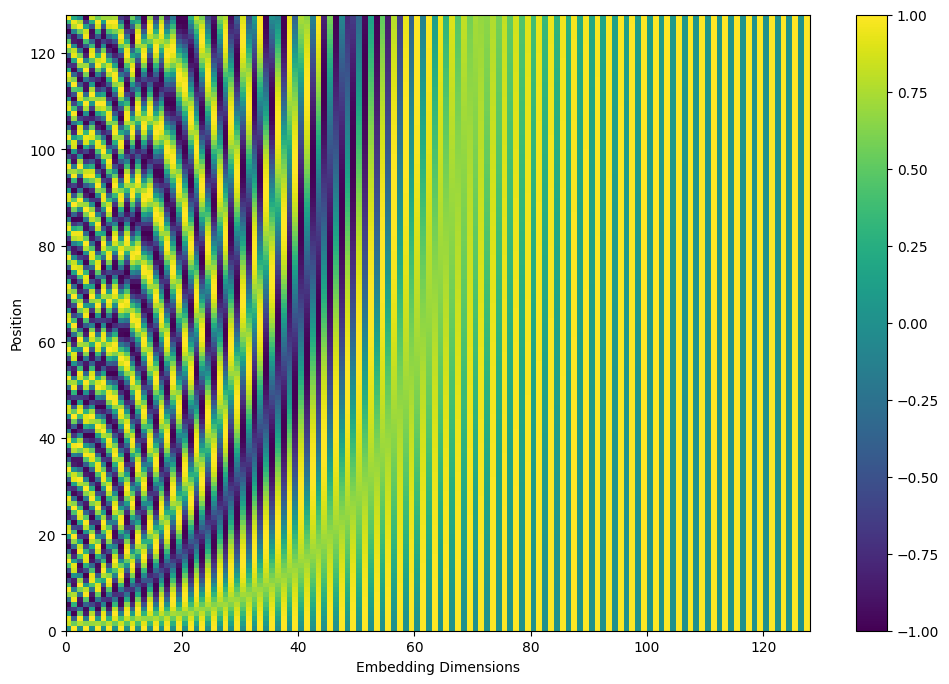

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.pcolormesh(pos_encoding, cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, emb_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Ahora, si pasamos nuestra frase simple por el tokenizador, deberíamos obtener una matriz con la forma: $(longitud, d_{model})$:

In [16]:
text = "hola mundo!"
tokens = ner_tokenizer(text, max_length=max_len, truncation=True, padding='max_length')
x = torch.tensor(tokens['input_ids']).unsqueeze(0)
mask = torch.tensor(tokens['input_ids']).unsqueeze(0)
embedding = tpe(x)
embedding.shape

torch.Size([1, 128, 128])

### Multi-Head Attention

![](../assets/mh-attention.png)

Ahora procedemos a definir al núcleo del modelo. Recodemos que la atención se define por:

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_K}})V
$$

Que es la definición de "Scaled Dot-Product Attention". Y Multi-Head Attention es la concatenación de varias cabezas ejecutando el mismo scaled dot-product sobre partes del input. Entonces tenemos:

In [17]:
import math


class MultiHeadAttention(nn.Module):

    def __init__(self, embed_size: int, num_heads: int = 8):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        assert embed_size & num_heads == 0, 'El tamaño del embedding debería ser divisible por el numero de cabezas'
        self.projection_dim = embed_size // num_heads
        self.query = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.value = nn.Linear(emb_dim, emb_dim)
        self.comibe_heads = nn.Linear(emb_dim, emb_dim)


    @staticmethod
    def _scaled_dot_product(q, k, v, mask=None):
        """scaled dot product.

        Esta función define el bloque mencionado.
        Aquí se hace la multiplicación de matrices
        entre los Q, K y V para luego calcular el 
        score de atención.

        Nótese además que aquí aplicamos una máscara
        de atención. Esto se debe a que como estamos
        rellenando las cadenas cortas con un token que
        en si mismo no trae ningún significado, no queremos
        que la red desperdicie recursos operando sobre este
        token, entonces usamos la máscara para poner los valores
        de atención en numeros muy pequeños para que al
        calcular el score, estos no sobresalgan sobre los demás.
        """
        # d_k para el escalamiento
        d_k = q.size()[-1]

        # multiplicacion Q \cdot K^T 
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        # escalamiento
        attn_logits = attn_logits / math.sqrt(d_k)
        
        # Se aplica la máscara
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask.reshape(mask.shape[0], 1, 1, -1) == 0, -9e-15)

        # Se calcula el score de atención.
        attention = torch.softmax(attn_logits, dim=-1)
        # Se obtienen los valores tras el score de atención.
        values = torch.matmul(attention, v)
        return values, attention
    

    def _separate_heads(self, x, batch_size):
        # Llega: (batch, seq_len, emb_dim)
        x =  x.reshape(batch_size, -1, self.num_heads, self.projection_dim)  # (batch, seq_len, num_heads, emb_dim / num_heads)
        return x.permute(0, 2, 1, 3)  # (batch, num_heads, seq_len, emb_dim / num_heads)
    

    def forward(self, x, mask=None, return_attention=False):
        """forward

        Este es todo el forward pass del multi-head attention.
        Aquí se coordina el resto de las operaciones, como
        la concatenación de las múltiples cabezas como 
        el paso por la capa densa previo a entregar el
        resultado.
        """
        # x: (batch, seq_len, emb_dim)
        batch_size, seq_len, emb_dim = x.size()
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        q = self._separate_heads(q, batch_size)
        k = self._separate_heads(k, batch_size)
        v = self._separate_heads(v, batch_size)

        weights, attention = self._scaled_dot_product(q, k, v, mask)
        weights = weights.permute(0, 2, 1, 3) # (batch, seq_len, num_heads, emb_dim / num_heads)
        weights = weights.reshape(batch_size, seq_len, emb_dim)
        output = self.comibe_heads(weights)
        
        if return_attention:
            return output, attention
        else:
            return output


Podemos hacer una prueba rápida de que las operaciones funcionan a nivel de matrices.

In [18]:
mha = MultiHeadAttention(emb_dim)
mha(embedding, mask).shape

torch.Size([1, 128, 128])

### Definición del bloque transformers

![](../assets/transformers-achitecture.png)

Finalmente, definimos el bloque de transformers. Recordemos que como esta es una tarea de clasificación, solamente necesitamos el encoder, por lo que esto es solamente la primera parte del diseño de arquitecura de red.

En esta capa, simplemente ponemos una capa densa adicional junto con las normalizaciones a nivel de capa.

In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim: int, num_heads: int = 8, ff_dim: int = 512, dropout: float = 0.1):
        super().__init__()
        self.mhatt = MultiHeadAttention(emb_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        
        self.ffn = nn.Sequential(
            nn.Linear(emb_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, emb_dim)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x, mask=None):
        # Multi-head attention with residual
        attn_output = self.mhatt(x, mask)
        x = x + self.dropout1(attn_output)
        x = self.layer_norm1(x)
        
        # Feed-forward with residual
        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)
        x = self.layer_norm2(x)
        
        return x


Nuevamente, probamos rapidamente para asegurarnos que las capas operan correctamente.

In [20]:
tb = TransformerBlock(emb_dim)
tb(embedding, mask).shape

torch.Size([1, 128, 128])

In [ ]:
'''num_heads = 8
vocab_size = spanish_news_tokenizer.vocab_size

token_embeddings = TokenAndPosEmbedding(max_len, emb_dim, vocab_size)
transformer = TransformerBlock(emb_dim, num_heads)
ff = nn.Sequential(
    nn.Flatten(),
    nn.Linear(max_len * emb_dim, spanish_news_dataset.num_classes)
)'''

In [ ]:

num_heads=8
labels = dataset.features["ner_tags"].feature.names
vocab_size = ner_tokenizer.vocab_size

num_labels = len(labels)  # Example: WikiANN has ~4 main classes (O, PER, ORG, LOC)

token_embeddings = TokenAndPosEmbedding(max_len, emb_dim, vocab_size)
transformer = TransformerBlock(emb_dim, num_heads)

# Instead of flattening, project each token embedding to num_labels
classifier = nn.Linear(emb_dim, num_labels)


In [22]:
it = iter(train_loader)
batch = next(it)

x, mask, y = batch['input_ids'], batch['attention_mask'], batch['labels']  # rename 'y' -> 'labels' if needed

# Embeddings
embeddings = token_embeddings(x)
print("Embeddings shape:", embeddings.shape)  # (batch_size, max_len, emb_dim)

# Transformer output
attention = transformer(embeddings, mask)
print("Transformer output shape:", attention.shape)  # (batch_size, max_len, emb_dim)

# Classifier output
logits = classifier(attention)
print("Logits shape:", logits.shape)  # (batch_size, max_len, num_labels)

# Check labels shape
print("Labels shape:", y.shape)  # (batch_size, max_len)


Embeddings shape: torch.Size([4, 128, 128])
Transformer output shape: torch.Size([4, 128, 128])
Logits shape: torch.Size([4, 128, 7])
Labels shape: torch.Size([4, 128])


In [24]:
pred = classifier(attention)
pred.shape

torch.Size([4, 128, 7])

### Definición del clasificador

Finalmente, definimos el modelo en si. Este modelo constará de 3 capas:

- La tokenización, tal como la definimos anteriormente.
- El transformer, que acabamos de decinir.
- Una capa densa adicional que servirá como clasificador de aquello que nos entregue la capa del transformer.

Como este es un LightningModule, aquí definiremos el resto de funciones utilitarias para el entrenamiento de la tarea.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule
from torchmetrics import Accuracy

class WikiANNTransformerNER(LightningModule):

    def __init__(self, max_len: int, vocab_size: int, num_labels: int, emb_dim: int, num_heads: int = 8, pad_idx: int = -100):
        super(WikiANNTransformerNER, self).__init__()
        self.save_hyperparameters()

        self.token_embeddings = TokenAndPosEmbedding(max_len, emb_dim, vocab_size)
        self.transformer = TransformerBlock(emb_dim, num_heads)
        self.classifier = nn.Linear(emb_dim, num_labels)

        # Metrics (compute accuracy ignoring padding)
        self.train_acc = Accuracy(task="multiclass", num_classes=num_labels, ignore_index=pad_idx)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_labels, ignore_index=pad_idx)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_labels, ignore_index=pad_idx)

        self.pad_idx = pad_idx

    def forward(self, x, mask=None):
        embeddings = self.token_embeddings(x)  # (B, L, D)
        attention = self.transformer(embeddings, mask)  # (B, L, D)
        logits = self.classifier(attention)  # (B, L, num_labels)
        return logits

    def shared_step(self, batch, stage: str):
        x, mask, y = batch['input_ids'], batch['attention_mask'], batch['labels']
        logits = self(x, mask)  # (B, L, num_labels)

        # Reshape for loss (flatten sequences)
        loss = F.cross_entropy(logits.view(-1, self.hparams.num_labels),
                               y.view(-1),
                               ignore_index=self.pad_idx)

        # Compute accuracy ignoring padding
        self.log(f"{stage}-loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss, logits, y

    def training_step(self, batch, batch_idx):
        loss, logits, y = self.shared_step(batch, "train")
        self.train_acc(logits.view(-1, self.hparams.num_labels), y.view(-1))
        self.log("train-acc", self.train_acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logits, y = self.shared_step(batch, "val")
        self.val_acc(logits.view(-1, self.hparams.num_labels), y.view(-1))
        self.log("val-acc", self.val_acc, prog_bar=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        _, logits, y = self.shared_step(batch, "test")
        self.test_acc(logits.view(-1, self.hparams.num_labels), y.view(-1))
        self.log("test-acc", self.test_acc, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=2e-5, weight_decay=1e-5)


In [28]:
num_labels = len(dataset.features["ner_tags"].feature.names)
pad_idx = -100  # HuggingFace datasets usually use this for ignored tokens

model = WikiANNTransformerNER(
    max_len=max_len,
    vocab_size=ner_tokenizer.vocab_size,
    num_labels=num_labels,
    emb_dim=emb_dim,
    num_heads=8,
    pad_idx=pad_idx
)

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer

tb_logger = TensorBoardLogger("tb_logs", name="WikiANN-TransformerNER")
callbacks = [EarlyStopping(monitor="val-loss", patience=3, mode="min")]

trainer = Trainer(
    max_epochs=20,
    devices=1,
    logger=tb_logger,
    callbacks=callbacks,
    precision="16-mixed"
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


Using 16bit Automatic Mixed Precision (AMP)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | token_embeddings | TokenAndPosEmbedding | 2.6 M  | train
1 | transformer      | TransformerBlock     | 198 K  | train
2 | classifier       | Linear               | 903    | train
3 | train_acc        | MulticlassAccuracy   | 0      | train
4 | val_acc          | MulticlassAccuracy   | 0      | train
5 | test_acc         | MulticlassAccuracy   | 0      | train
------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total p

Epoch 19: 100%|██████████| 4000/4000 [00:28<00:00, 141.27it/s, v_num=1, train-acc_step=1.000, val-loss=0.775, val-acc=0.720, train-loss=0.697, train-acc_epoch=0.751]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4000/4000 [00:28<00:00, 140.67it/s, v_num=1, train-acc_step=1.000, val-loss=0.775, val-acc=0.720, train-loss=0.697, train-acc_epoch=0.751]


Observemos el proceso de entrenamiento

In [25]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir tb_logs/

Y como es de esperarse, realizaremos la validación contra el conjunto de prueba.

In [29]:
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 500/500 [00:01<00:00, 317.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test-acc          │    0.7082191109657288     │
│         test-loss         │    0.8160772919654846     │
└───────────────────────────┴───────────────────────────┘

[{'test-loss': 0.8160772919654846, 'test-acc': 0.7082191109657288}]

### Haciendo predicciones

Finalmente, vamos a hacer uso del modelo y ver que tan bueno es para la clasificación de noticias.

In [30]:
predictions = trainer.predict(model, test_loader)
predictions = torch.cat(predictions, dim=0)
predictions = torch.argmax(predictions, dim=-1)
predictions = [ner_dataset.id_2_class_map[pred] for pred in predictions.numpy()]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/500 [00:00<?, ?it/s]

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not dict

In [31]:
# 1. Hacer predicciones
predictions = trainer.predict(model, test_loader)  # lista de batches

# 2. Concatenar todos los batches
predictions = torch.cat(predictions, dim=0)  # shape (num_examples, seq_len, num_labels)

# 3. Obtener la clase con mayor score por token
predicted_ids = torch.argmax(predictions, dim=-1)  # shape (num_examples, seq_len)

# 4. Mapear a etiquetas NER reales, ignorando padding tokens
predicted_labels = []
for i, seq in enumerate(predicted_ids):
    seq_labels = []
    for j, token_id in enumerate(seq):
        # asumiendo que el padding de labels es -100
        if ner_dataset.labels[i][j] != -100:  
            seq_labels.append(ner_dataset.id_2_class_map[token_id.item()])
    predicted_labels.append(seq_labels)

# predicted_labels es ahora una lista de listas de etiquetas por ejemplo
print(predicted_labels[0])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/500 [06:57<?, ?it/s]


TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not dict

In [43]:
# ===== CELL 1: Fix the predict_step method =====
# Add this method to your WikiANNTransformerNER class

def predict_step(self, batch, batch_idx):
    """Prediction step for inference - fixed to handle batch properly"""
    # Extract tensors from batch dictionary
    x = batch['input_ids']
    mask = batch['attention_mask']
    
    # Forward pass
    logits = self(x, mask)  # Now calling forward with proper arguments
    predictions = torch.argmax(logits, dim=-1)
    
    return {
        'predictions': predictions,
        'attention_mask': mask,
        'labels': batch.get('labels', None)
    }

# Add the method to your existing class
WikiANNTransformerNER.predict_step = predict_step

print("Added predict_step method to WikiANNTransformerNER class")

# ===== CELL 2: Run predictions (this should work now) =====
print("Running predictions...")
predictions_list = trainer.predict(model, test_loader)
print(f"Got predictions for {len(predictions_list)} batches")

# ===== CELL 3: Process predictions properly =====
def process_predictions(predictions_list, dataset, id_2_class_map):
    """Process the predictions from trainer.predict()"""
    
    all_predictions = []
    all_true_labels = []
    
    for batch_results in predictions_list:
        pred_ids = batch_results['predictions']  # (batch_size, seq_len)
        attention_masks = batch_results['attention_mask']  # (batch_size, seq_len)
        true_labels = batch_results.get('labels', None)
        
        # Process each sequence in the batch
        for i in range(pred_ids.size(0)):
            seq_preds = pred_ids[i]
            seq_mask = attention_masks[i]
            
            # Get only valid (non-padded) predictions
            valid_preds = seq_preds[seq_mask == 1]
            
            # Convert to label names
            pred_labels = [id_2_class_map.get(pred.item(), 'O') for pred in valid_preds]
            all_predictions.extend(pred_labels)
            
            # Process true labels if available
            if true_labels is not None:
                seq_true = true_labels[i]
                valid_true = seq_true[seq_mask == 1]
                # Remove padding labels (-100)
                valid_true = valid_true[valid_true != -100]
                true_label_names = [id_2_class_map.get(label.item(), 'O') for label in valid_true]
                all_true_labels.extend(true_label_names)
    
    return all_predictions, all_true_labels if all_true_labels else None

# Use the id_2_class mapping from your dataset
id_2_class_map = train_dataset.dataset.id_2_class
predictions, true_labels = process_predictions(predictions_list, test_dataset, id_2_class_map)

print(f"Processed {len(predictions)} predictions")
if true_labels:
    print(f"Processed {len(true_labels)} true labels")

# ===== CELL 4: Calculate metrics =====
if true_labels:
    from sklearn.metrics import classification_report, accuracy_score
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions))
    
    # Entity-level metrics (excluding 'O' tags)
    entity_true = [label for label in true_labels if label != 'O']
    entity_pred = [pred for pred, true in zip(predictions, true_labels) if true != 'O']
    
    if entity_true:
        entity_accuracy = accuracy_score(entity_true, entity_pred)
        print(f"\nEntity-only Accuracy: {entity_accuracy:.4f}")
        print("\nEntity Classification Report:")
        print(classification_report(entity_true, entity_pred))

# ===== CELL 5: Show sample predictions with original tokens =====
def show_detailed_predictions(model, test_dataset, test_loader, trainer, num_samples=3):
    """Show predictions aligned with original tokens"""
    
    predictions_list = trainer.predict(model, test_loader)
    
    sample_count = 0
    batch_idx = 0
    
    for batch_results in predictions_list:
        if sample_count >= num_samples:
            break
            
        pred_ids = batch_results['predictions']
        attention_masks = batch_results['attention_mask']
        
        for i in range(pred_ids.size(0)):
            if sample_count >= num_samples:
                break
                
            # Calculate the actual index in the dataset
            actual_idx = batch_idx * test_loader.batch_size + i
            if actual_idx >= len(test_dataset):
                break
                
            # Get original example
            original_example = test_dataset.dataset[test_dataset.indices[actual_idx]]
            original_tokens = original_example['tokens']
            original_labels = [test_dataset.dataset.id_2_class[label] for label in original_example['ner_tags']]
            
            # Get predictions for this sequence
            seq_predictions = pred_ids[i]
            seq_mask = attention_masks[i]
            
            # Filter predictions by attention mask
            valid_predictions = seq_predictions[seq_mask == 1]
            pred_labels = [test_dataset.dataset.id_2_class.get(pred.item(), 'O') for pred in valid_predictions]
            
            # Align with original tokens (take first N predictions where N = len(original_tokens))
            aligned_predictions = pred_labels[:len(original_tokens)]
            
            print(f"\n=== Sample {sample_count + 1} ===")
            print("Token        | True       | Predicted  | Match")
            print("-" * 50)
            
            for j, token in enumerate(original_tokens):
                true_label = original_labels[j] if j < len(original_labels) else 'O'
                pred_label = aligned_predictions[j] if j < len(aligned_predictions) else 'O'
                match_symbol = "✓" if true_label == pred_label else "✗"
                print(f"{token:12} | {true_label:10} | {pred_label:10} | {match_symbol}")
            
            sample_count += 1
        
        batch_idx += 1
    
    return sample_count



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Added predict_step method to WikiANNTransformerNER class
Running predictions...
Predicting DataLoader 0: 100%|██████████| 500/500 [00:01<00:00, 453.41it/s]
Got predictions for 500 batches
Processed 16413 predictions
Processed 16413 true labels
Overall Accuracy: 0.7082

Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.64      0.55      0.59      1242
       B-ORG       0.62      0.43      0.51      1067
       B-PER       0.55      0.51      0.53      1068
       I-LOC       0.61      0.48      0.54      1564
       I-ORG       0.68      0.65      0.66      3077
       I-PER       0.52      0.61      0.56      2178
           O       0.85      0.95      0.89      6217

    accuracy                           0.71     16413
   macro avg       0.64      0.59      0.61     16413
weighted avg       0.70      0.71      0.70     16413


Entity-only Accuracy: 0.5631

Entity Classification Report:
              precision    recall  f1-score   sup

In [42]:
import pandas as pd

# First, let's group predictions by sample instead of having all tokens in one list
def group_predictions_by_sample(predictions_list, test_dataset, id_2_class_map):
    """Group predictions by sample to match dataset structure"""
    
    sample_predictions = []
    sample_idx = 0
    
    for batch_results in predictions_list:
        pred_ids = batch_results['predictions']  # (batch_size, seq_len)
        attention_masks = batch_results['attention_mask']  # (batch_size, seq_len)
        
        for i in range(pred_ids.size(0)):
            if sample_idx >= len(test_dataset):
                break
                
            # Get original sample to know how many tokens it has
            original_idx = test_dataset.indices[sample_idx]
            original_tokens = dataset[original_idx]['tokens']
            
            # Get predictions for this sequence
            seq_predictions = pred_ids[i]
            seq_mask = attention_masks[i]
            
            # Filter predictions by attention mask
            valid_predictions = seq_predictions[seq_mask == 1]
            pred_labels = [id_2_class_map.get(pred.item(), 'O') for pred in valid_predictions]
            
            # Truncate to match original token count
            aligned_predictions = pred_labels[:len(original_tokens)]
            
            sample_predictions.append(aligned_predictions)
            sample_idx += 1
    
    return sample_predictions

# Group your predictions by sample
print("Grouping predictions by sample...")
sample_predictions = group_predictions_by_sample(predictions_list, test_dataset, train_dataset.dataset.id_2_class)
print(f"Grouped into {len(sample_predictions)} samples")

# Get test indices
test_indices = test_dataset.indices

# Create DataFrame adapted for NER dataset
df = pd.DataFrame(data={
    "tokens": [dataset[idx]['tokens'] for idx in test_indices],
    "token_ids": [ner_tokenizer(dataset[idx]['tokens'], is_split_into_words=True)['input_ids'] for idx in test_indices],
    "true_labels": [[train_dataset.dataset.id_2_class[label] for label in dataset[idx]['ner_tags']] for idx in test_indices],
    'predicted_labels': sample_predictions[:len(test_indices)]  # Use grouped predictions
}, index=test_indices)

# Add token strings (convert token IDs back to readable tokens)
df['token_strings'] = df.token_ids.apply(lambda t: ner_tokenizer.convert_ids_to_tokens(t))

# Reorder columns for better readability
df = df[["tokens", "token_ids", "token_strings", "true_labels", "predicted_labels"]]

# Style the DataFrame for better display
styled_df = df.style.set_table_styles(
    [
        {'selector': 'td', 'props': [('word-wrap', 'break-word')]}
    ]
)

print(f"DataFrame created with {len(df)} samples")
df.head(15)

Grouping predictions by sample...
Grouped into 2000 samples
DataFrame created with 2000 samples


,tokens,token_ids,token_strings,true_labels,predicted_labels
16138,"[Escala, de, huracanes, de, Saffir-Simpson]","[794, 703, 260, 8954, 2223, 289, 260, 694, 867...","[ĠEsc, ala, Ġde, Ġhura, can, es, Ġde, ĠSa, ff,...","[B-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[B-ORG, I-ORG, I-ORG, I-ORG, I-ORG]"
19249,"[*El, primer, cuartel, simboliza, las, Islas, ...","[438, 3227, 2198, 990, 17310, 6294, 434, 1445,...","[Ġ*, El, Ġprimer, Ġcu, artel, Ġsim, bol, iza, ...","[O, O, O, O, O, B-LOC, I-LOC, O]","[O, O, O, O, O, O, O, O]"
5649,"[REDIRECCIÓN, Tubérculo, menor, del, húmero]","[276, 10777, 6464, 280, 360, 8957]","[ĠREDIRECCIÃĵN, ĠTubÃ©rculo, Ġmen, or, Ġdel, Ġ...","[O, B-LOC, I-LOC, I-LOC, I-LOC]","[O, B-LOC, B-LOC, I-LOC, I-LOC]"
11211,"[', '', Coquimbo, Unido, '', ']","[257, 262, 4381, 1312, 262, 257]","[Ġ', Ġ'', ĠCoquimbo, ĠUnido, Ġ'', Ġ']","[O, O, B-ORG, I-ORG, O, O]","[O, O, I-PER, I-PER, O, O]"
18077,"[====, Circuitos, Continentales, UCI, ====]","[2051, 3184, 5132, 15376, 3048, 6286, 2051]","[Ġ====, ĠCircu, itos, ĠContin, entales, ĠUCI, ...","[O, B-ORG, I-ORG, I-ORG, O]","[O, B-PER, I-PER, I-PER, I-PER]"
12921,"[junto, a, Ben, Chaplin, y, Idris, Elba]","[1009, 342, 839, 2623, 1979, 337, 6254, 865, 1...","[Ġjunto, Ġa, ĠBen, ĠChap, lin, Ġy, ĠId, ris, Ġ...","[O, O, B-PER, I-PER, O, B-PER, I-PER]","[O, O, B-PER, I-PER, I-ORG, I-PER, I-PER]"
9350,"[REDIRECCIÓN, The, World, We, Live, In]","[276, 592, 1803, 2445, 2398, 430]","[ĠREDIRECCIÃĵN, ĠThe, ĠWorld, ĠWe, ĠLive, ĠIn]","[O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG]"
12190,"[===, Universal, /, PolyGram, ===]","[761, 4386, 499, 885, 89, 39, 4992, 761]","[Ġ===, ĠUniversal, Ġ/, ĠPol, y, G, ram, Ġ===]","[O, B-ORG, O, B-ORG, O]","[O, I-PER, O, I-ORG, I-PER]"
12414,"[Partido, Comunista, de, Alemania, (, Oposició...","[575, 2191, 260, 541, 286, 15022, 287]","[ĠPartido, ĠComunista, Ġde, ĠAlemania, Ġ(, ĠOp...","[B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]"
10482,"[Santa, María, del, Oro]","[723, 547, 360, 1770]","[ĠSanta, ĠMarÃŃa, Ġdel, ĠOro]","[B-LOC, I-LOC, I-LOC, I-LOC]","[B-LOC, I-PER, I-PER, I-PER]"


In [44]:
errors = df[df['true_labels'] != df['predicted_labels']]
errors.head(15)

,tokens,token_ids,token_strings,true_labels,predicted_labels
19249,"[*El, primer, cuartel, simboliza, las, Islas, ...","[438, 3227, 2198, 990, 17310, 6294, 434, 1445,...","[Ġ*, El, Ġprimer, Ġcu, artel, Ġsim, bol, iza, ...","[O, O, O, O, O, B-LOC, I-LOC, O]","[O, O, O, O, O, O, O, O]"
5649,"[REDIRECCIÓN, Tubérculo, menor, del, húmero]","[276, 10777, 6464, 280, 360, 8957]","[ĠREDIRECCIÃĵN, ĠTubÃ©rculo, Ġmen, or, Ġdel, Ġ...","[O, B-LOC, I-LOC, I-LOC, I-LOC]","[O, B-LOC, B-LOC, I-LOC, I-LOC]"
11211,"[', '', Coquimbo, Unido, '', ']","[257, 262, 4381, 1312, 262, 257]","[Ġ', Ġ'', ĠCoquimbo, ĠUnido, Ġ'', Ġ']","[O, O, B-ORG, I-ORG, O, O]","[O, O, I-PER, I-PER, O, O]"
18077,"[====, Circuitos, Continentales, UCI, ====]","[2051, 3184, 5132, 15376, 3048, 6286, 2051]","[Ġ====, ĠCircu, itos, ĠContin, entales, ĠUCI, ...","[O, B-ORG, I-ORG, I-ORG, O]","[O, B-PER, I-PER, I-PER, I-PER]"
12921,"[junto, a, Ben, Chaplin, y, Idris, Elba]","[1009, 342, 839, 2623, 1979, 337, 6254, 865, 1...","[Ġjunto, Ġa, ĠBen, ĠChap, lin, Ġy, ĠId, ris, Ġ...","[O, O, B-PER, I-PER, O, B-PER, I-PER]","[O, O, B-PER, I-PER, I-ORG, I-PER, I-PER]"
12190,"[===, Universal, /, PolyGram, ===]","[761, 4386, 499, 885, 89, 39, 4992, 761]","[Ġ===, ĠUniversal, Ġ/, ĠPol, y, G, ram, Ġ===]","[O, B-ORG, O, B-ORG, O]","[O, I-PER, O, I-ORG, I-PER]"
10482,"[Santa, María, del, Oro]","[723, 547, 360, 1770]","[ĠSanta, ĠMarÃŃa, Ġdel, ĠOro]","[B-LOC, I-LOC, I-LOC, I-LOC]","[B-LOC, I-PER, I-PER, I-PER]"
6427,"[Comarca, de, El, Morrazo]","[2646, 260, 437, 18436]","[ĠComarca, Ġde, ĠEl, ĠMorrazo]","[B-LOC, I-LOC, I-LOC, I-LOC]","[B-LOC, I-LOC, B-LOC, I-LOC]"
5138,"[REDIRECCIÓN, Sebastián, Cirac, Estopañán]","[276, 2686, 18119, 6313, 19617]","[ĠREDIRECCIÃĵN, ĠSebastiÃ¡n, ĠCirac, ĠEsto, pa...","[O, B-PER, I-PER, I-PER]","[O, B-LOC, B-PER, I-PER]"
14327,"[**, Perales, de, Tajuña, .]","[453, 605, 608, 260, 19388, 288]","[Ġ**, ĠPer, ales, Ġde, ĠTajuÃ±a, Ġ.]","[O, B-LOC, I-LOC, I-LOC, O]","[O, B-LOC, O, I-LOC, B-LOC]"


## Conclusiones
- El performance del modelo es staisfactorio. La exerimentacion sugiere que usar mas epocas podria ser ideal para subir esas metricas. 